# Organisation notebook
This notebook is for all of the things involved in the image classification that are not the actual model training/validation/inference:
- classification into day/night images'
- sorting datasets into balanced test/train/val sets 
- checking how many instances of classes are in a labels folder
- relabelling of images by replacing values in the label files
- Deleting duplicate images from training/val datasets to prevent data leakage

In [2]:
import shutil
import cv2

import os
import pandas as pd
import time
from glob import glob
import re
import numpy as np
from tqdm import tqdm
from skmultilearn.model_selection import iterative_train_test_split
from PIL import Image

## Sort images into day/night
- This classifies images in any directory into day/night images based on hue
- It misses some images (<10 per 1000) so some manual checking is needed

Specifically for labelled images

In [2]:
# Define the source directory and the target directories for day and night images
image_source_directory = "C:\\Users\\willo\\OneDrive - UNSW\\Documents\\Work\\CES\\Wild Deserts\\Image classification\\feedback_loop\\v1_night_16012025\\images\\val"
label_source_directory = "C:\\Users\\willo\\OneDrive - UNSW\\Documents\\Work\\CES\\Wild Deserts\\Image classification\\feedback_loop\\v1_night_16012025\\labels\\val"

#day_directory_images = "D:\\Wild deserts photos\\model_val\\day_images\\val\\images"
#day_directory_labels = "D:\\Wild deserts photos\\model_val\\day_images\\val\\labels"

#night_directory_images = "D:\\Wild deserts photos\\model_val\\night_images\\val\\images"
#night_directory_labels = "D:\\Wild deserts photos\\model_val\\night_images\\val\\images"

# Create the target directories if they do not exist
#os.makedirs(day_directory_images, exist_ok=True)
#os.makedirs(day_directory_labels, exist_ok=True)
#os.makedirs(night_directory_images, exist_ok=True)
#os.makedirs(night_directory_labels, exist_ok=True)

def classify_image(image_path):
    image = cv2.imread(image_path)
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    brightness = hsv_image[:, :, 2].mean()  # V channel represents brightness
    hue = hsv_image[:, :, 0].mean()  # H channel represents hue
    # Adjust the thresholds as needed
    if hue > 10:
        return 'day'
    else:
        return 'night'

# Classify and copy images and labels
for filename in os.listdir(image_source_directory):
    if filename.endswith(".JPG") or filename.endswith(".jpg"):
        image_path = os.path.join(image_source_directory, filename)
        label_path = os.path.join(label_source_directory, filename.replace(".JPG", ".txt").replace(".jpg", ".txt"))
        print(f"Classifying {image_path}")
        classification = classify_image(image_path)
        if classification == 'day':
            os.remove(image_path)
            os.remove(label_path)
        else:
            continue
            #shutil.copy(image_path, os.path.join(night_directory_images, filename))
            #shutil.copy(label_path, os.path.join(night_directory_labels, os.path.basename(label_path)))

print("Classification and copying completed!")

Classifying C:\Users\willo\OneDrive - UNSW\Documents\Work\CES\Wild Deserts\Image classification\feedback_loop\v1_night_16012025\images\val\2017-11-08 21-50-40 M 1_3.JPG
Classifying C:\Users\willo\OneDrive - UNSW\Documents\Work\CES\Wild Deserts\Image classification\feedback_loop\v1_night_16012025\images\val\2017-11-08 23-09-43 M 2_3.JPG
Classifying C:\Users\willo\OneDrive - UNSW\Documents\Work\CES\Wild Deserts\Image classification\feedback_loop\v1_night_16012025\images\val\2017-11-08 23-50-20 M 2_3.JPG
Classifying C:\Users\willo\OneDrive - UNSW\Documents\Work\CES\Wild Deserts\Image classification\feedback_loop\v1_night_16012025\images\val\2017-11-11 06-16-16 M 1_3.JPG
Classifying C:\Users\willo\OneDrive - UNSW\Documents\Work\CES\Wild Deserts\Image classification\feedback_loop\v1_night_16012025\images\val\2017-11-11 06-51-53 M 2_3.JPG
Classifying C:\Users\willo\OneDrive - UNSW\Documents\Work\CES\Wild Deserts\Image classification\feedback_loop\v1_night_16012025\images\val\2017-11-11 22-48

For unlabelled images/just a directory of images

In [3]:
# Define the source directory and the target directories for day and night images
image_source_directory = "C:\\Users\\willo\\OneDrive - UNSW\\Documents\\Work\\CES\\Wild Deserts\\Wyze paired\\december PCAM07"

day_directory_images = "C:\\Users\\willo\\OneDrive - UNSW\\Documents\\Work\\CES\\Wild Deserts\\Wyze paired\\december PCAM07\\day"

night_directory_images = "C:\\Users\\willo\\OneDrive - UNSW\\Documents\\Work\\CES\\Wild Deserts\\Wyze paired\\december PCAM07\\night"

# Create the target directories if they do not exist
os.makedirs(day_directory_images, exist_ok=True)
os.makedirs(night_directory_images, exist_ok=True)

def classify_image(image_path):
    image = cv2.imread(image_path)
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    brightness = hsv_image[:, :, 2].mean()  # V channel represents brightness
    hue = hsv_image[:, :, 0].mean()  # H channel represents hue
    # Adjust the thresholds as needed
    if hue > 10:
        return 'day'
    else:
        return 'night'

# Classify and copy images
for filename in os.listdir(image_source_directory):
    if filename.endswith(".JPG") or filename.endswith(".jpg"):
        image_path = os.path.join(image_source_directory, filename)
        print(image_path)
        classification = classify_image(image_path)
        if classification == 'day':
            shutil.copy(image_path, os.path.join(day_directory_images, filename))
        else:
            shutil.copy(image_path, os.path.join(night_directory_images, filename))

print("Classification and copying completed!")

C:\Users\willo\OneDrive - UNSW\Documents\Work\CES\Wild Deserts\Wyze paired\december PCAM07\RCNX0001.JPG
C:\Users\willo\OneDrive - UNSW\Documents\Work\CES\Wild Deserts\Wyze paired\december PCAM07\RCNX0002.JPG
C:\Users\willo\OneDrive - UNSW\Documents\Work\CES\Wild Deserts\Wyze paired\december PCAM07\RCNX0003.JPG
C:\Users\willo\OneDrive - UNSW\Documents\Work\CES\Wild Deserts\Wyze paired\december PCAM07\RCNX0004.JPG
C:\Users\willo\OneDrive - UNSW\Documents\Work\CES\Wild Deserts\Wyze paired\december PCAM07\RCNX0005.JPG
C:\Users\willo\OneDrive - UNSW\Documents\Work\CES\Wild Deserts\Wyze paired\december PCAM07\RCNX0006.JPG
C:\Users\willo\OneDrive - UNSW\Documents\Work\CES\Wild Deserts\Wyze paired\december PCAM07\RCNX0007.JPG
C:\Users\willo\OneDrive - UNSW\Documents\Work\CES\Wild Deserts\Wyze paired\december PCAM07\RCNX0008.JPG
C:\Users\willo\OneDrive - UNSW\Documents\Work\CES\Wild Deserts\Wyze paired\december PCAM07\RCNX0009.JPG
C:\Users\willo\OneDrive - UNSW\Documents\Work\CES\Wild Deserts\W

## Reclassify labels and split into train/val sets
- This uses some basic text editing to replace values that are being reclassified
- Faster than reclassifying using X-Anylabel
- I also split images into new test/train/val sets after reclassifying.
    - I use iterative_train_test_split from Scikit-multilearn to perform stratified classification because of the imbalanced dataset
    


### Reclassification
- remember to change the to_remove and the species

In [41]:
for file_path in glob('E:\\Wild deserts photos\\model_training\\animal_detector\\labels\\val\\*.txt'):
    print(f'{file_path}')
    with open(file_path, 'r', encoding='utf-8') as file:
        lines = file.readlines()
        modified_lines = []
        for line in lines:
            to_remove = re.match(r'^(8 )', line)
            animal = re.match(r'^(0 |1 |2 |3 |4 |5 |6 |7)', line)
            # rabbit = re.match(r'^(11 )', line)
            #dingo = re.match(r'^(2 )', line)
            #fox = re.match(r'^(6 )', line)
            if to_remove:
                continue  # Skip appending this line
            elif animal:
                modified_line = re.sub(r'^(0 |1 |2 |3 |4 |5 |6 |7)', '0 ', line)
            # elif rabbit:
            #     modified_line = re.sub(r'^(11 )', "2 ", line)
            #elif dingo:
            #    modified_line = re.sub(r'^(2 )', "3 ", line)  
            #elif fox:
            #    modified_line = re.sub(r'^(6 )', "4 ", line)  
            else:
                modified_line = line  
            
            modified_lines.append(modified_line)
    with open(file_path, 'w', encoding='utf-8') as file:
        file.writelines(modified_lines)
        print(f'File written to: {file_path}')

print("Done!")

E:\Wild deserts photos\model_training\animal_detector\labels\val\2018-01-15 01-42-51 M 1_3.txt
File written to: E:\Wild deserts photos\model_training\animal_detector\labels\val\2018-01-15 01-42-51 M 1_3.txt
E:\Wild deserts photos\model_training\animal_detector\labels\val\2018-01-15 04-04-11 M 3_3.txt
File written to: E:\Wild deserts photos\model_training\animal_detector\labels\val\2018-01-15 04-04-11 M 3_3.txt
E:\Wild deserts photos\model_training\animal_detector\labels\val\2018-01-16 03-59-00 M 1_3.txt
File written to: E:\Wild deserts photos\model_training\animal_detector\labels\val\2018-01-16 03-59-00 M 1_3.txt
E:\Wild deserts photos\model_training\animal_detector\labels\val\2018-01-18 02-45-39 M 1_3.txt
File written to: E:\Wild deserts photos\model_training\animal_detector\labels\val\2018-01-18 02-45-39 M 1_3.txt
E:\Wild deserts photos\model_training\animal_detector\labels\val\2018-01-19 05-29-38 M 1_3.txt
File written to: E:\Wild deserts photos\model_training\animal_detector\labels

### Split the reclassified images
- remember to change the 4D zero vector according to the number of classes you have

In [3]:

# Path to your YOLO .txt annotations
annotations_path = "E:\\Wild deserts photos\\model_training\\dayv4\\labels\\*.txt"

# List all .txt files
txt_files = glob(annotations_path)

X = []  # Will store image paths or anything representing the "features"
y = []  # Will store the multi-label vectors of shape (16,)

for txt_file in txt_files:
    # Construct the corresponding image path
    # (assuming .jpg files, adjust if your images are .png, etc.)
    img_file = txt_file.replace(".txt", ".JPG")
    img_file = img_file.replace("labels", "images")
    # Initialize a 4-dimensional zero vector for the labels !!! MAKE SURE TO CHANGE IF YOU HAVE MORE CLASSES !!!
    labels = np.zeros(5, dtype=int)
    print(txt_file)
    # Read the YOLO annotation file
    with open(txt_file, "r") as f:
        for line in f:
            items = line.strip().split()
            if len(items) >= 5:
                class_id = int(items[0])
                # Mark that class_id as present
                labels[class_id] = 1

    # Append to X and y
    X.append(img_file)     # or store actual image data if needed
    y.append(labels)

X = np.array(X)
X = X.reshape(-1, 1)
y = np.array(y)
print("Data extracted into numpy arrays")

val_size = 0.15 #20% of the data will be used for test

# Perform the iterative train/test split
X_train, y_train, X_val, y_val = iterative_train_test_split(X, y, test_size=val_size)
X_val = X_val.ravel()  
X_train = X_train.ravel()
print("Proportions:")
print("  train:", X_train.shape, y_train.shape)
print("  val:     ", X_val.shape,    y_val.shape)

# Summarize the TRAIN data
train_counts = y_train.sum(axis=0)
print(f"TRAIN - counts per class: {train_counts}")
print(f"TRAIN - total samples: {len(y_train)}\n")

# Summarize the TEST data
val_counts = y_val.sum(axis=0)
print(f"VAL - counts per class: {val_counts}")
print(f"VAL - total samples: {len(y_val)}\n")



E:\Wild deserts photos\model_training\dayv4\labels\RCNX4080.txt
E:\Wild deserts photos\model_training\dayv4\labels\2017-11-11 06-16-16 M 1_3.txt
E:\Wild deserts photos\model_training\dayv4\labels\2017-11-11 06-51-53 M 2_3.txt
E:\Wild deserts photos\model_training\dayv4\labels\2017-11-11 07-25-31 M 1_3.txt
E:\Wild deserts photos\model_training\dayv4\labels\2017-11-12 12-16-37 M 1_3.txt
E:\Wild deserts photos\model_training\dayv4\labels\2017-11-15 08-16-48 M 1_3.txt
E:\Wild deserts photos\model_training\dayv4\labels\2017-11-17 07-14-21 M 2_3.txt
E:\Wild deserts photos\model_training\dayv4\labels\2017-11-19 06-14-17 M 1_3.txt
E:\Wild deserts photos\model_training\dayv4\labels\2017-11-19 06-14-59 M 1_3.txt
E:\Wild deserts photos\model_training\dayv4\labels\2017-11-20 05-53-21 M 2_3.txt
E:\Wild deserts photos\model_training\dayv4\labels\2017-11-25 18-56-55 M 1_3.txt
E:\Wild deserts photos\model_training\dayv4\labels\2017-11-28 06-28-22 M 1_3.txt
E:\Wild deserts photos\model_training\dayv4\l

Move files into the correct folders

In [4]:
#Change these to your directories
labels_dir = "E:\\Wild deserts photos\\model_training\\dayv4\\labels"
images_dir = "E:\\Wild deserts photos\\model_training\\dayv4\\images"
# Create "labels" and "images" folders in each directory
for directory in [labels_dir, images_dir]:
    os.makedirs(os.path.join(directory, "val"), exist_ok=True)
    os.makedirs(os.path.join(directory, "train"), exist_ok=True)
    #os.makedirs(os.path.join(directory, "val"), exist_ok=True)
# Copy test images and labels. Note that this leaves the files in the original directories too
for img_path in tqdm(X_val, desc="Copying val data"):
    
    txt_path = img_path.replace(".JPG", ".txt")
    txt_path = txt_path.replace("images", "labels")

    shutil.move(img_path, os.path.join(images_dir, "val"))
    shutil.move(txt_path, os.path.join(labels_dir, "val"))
# Copy training images and labels
for img_path in tqdm(X_train, desc="Copying training data"):
    txt_path = img_path.replace(".JPG", ".txt")  # or .png, whichever you have
    txt_path = txt_path.replace("images", "labels")
    shutil.move(img_path, os.path.join(images_dir, "train"))
    shutil.move(txt_path, os.path.join(labels_dir, "train"))


Copying training data: 100%|██████████| 2507/2507 [00:22<00:00, 112.62it/s]


## Delete duplicate images from two directories

In [ ]:
import os

# Define the directories
dir2 = "C:\\Users\\willo\\OneDrive - UNSW\\Documents\\Work\\CES\\Wild Deserts\\Image classification\\feedback_loop\\v1_night_16012025\\images\\val"
# Walk through all subdirectories in the root directory
for root, dirs, files in os.walk("D:\\Wild deserts photos\\Reconyx"):
    # Get the list of image files in each subdirectory
    images_dir1 = set(os.listdir(root))
    images_dir2 = set(os.listdir(dir2))

    # Find the intersection of the two sets
    shared_images = images_dir1.intersection(images_dir2)

    # Delete the shared images from the current subdirectory
    for image in shared_images:
        print(image)
        image_path = os.path.join(root, image)
        if os.path.exists(image_path):
            os.remove(image_path)
            print(f"Deleted {image_path}")


## Check distribution of labels in directory 
- Need to remember to change the classes file and also the directory

In [12]:
import os

# Define the YOLO classes in the correct order
CLASSES = [
"Kangaroo",
"Cat",
"Rabbit",
"Dingo",
"Fox",
]

# Define a background category that is not part of the original YOLO classes
BACKGROUND_CATEGORY = "Background"

# Path to your folder containing .txt annotation files
folder_path = r"E:\Wild deserts photos\model_training\dayv4\labels\train"

# Create a count dictionary initialized to zero for each class and background
label_counts = {cls: 0 for cls in CLASSES}
label_counts[BACKGROUND_CATEGORY] = 0

# Loop through all .txt files in the folder
for filename in os.listdir(folder_path):
    if filename.endswith(".txt"):
        
        txt_file_path = os.path.join(folder_path, filename)
        
        with open(txt_file_path, "r") as file:
            lines = file.readlines()
            
            # Check if the file has any non-empty lines
            if not any(line.strip() for line in lines):
                # If no labels are present, count as background
                label_counts[BACKGROUND_CATEGORY] += 1
            else:
                # Otherwise, process each line as usual
                for line in lines:
                    line = line.strip()
                    if line:
                        class_index = int(line.split()[0])  # YOLO class index
                        label_counts[CLASSES[class_index]] += 1

# Print out the counts per class including background
for cls_name, cls_count in label_counts.items():
    print(f"{cls_name}: {cls_count}")


Kangaroo: 1533
Cat: 132
Rabbit: 103
Dingo: 76
Fox: 0
Background: 1058


Plot distribution

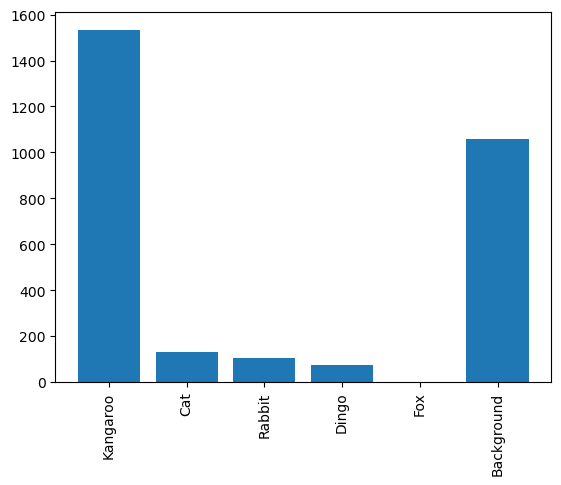

<Figure size 1000x600 with 0 Axes>

In [13]:
import matplotlib.pyplot as plt
plt.bar(range(len(label_counts)), list(label_counts.values()), align='center')
plt.xticks(range(len(label_counts)), list(label_counts.keys()))
plt.tick_params(axis='x', labelrotation=90) 
plt.figure(figsize=(10, 6))
plt.show()

## Copy images that are needed for more training

In [10]:
import os
import shutil

# --- Configuration ---

# List of YOLO classes in order (adjust to your own class list)
CLASSES = [
    "Kangaroo", 
    "Cat", 
    "Rabbit", 
    "Dingo", 
    "Fox"
]

# Specify which classes you want to extract (by name)
desired_classes = ["Cat", "Rabbit", "Dingo", "Fox"]

# Convert desired class names to their corresponding indices.
desired_indices = [CLASSES.index(cls) for cls in desired_classes]

# Paths (update these to point to your folders)
label_folder = "C:\\Users\\willo\\OneDrive - UNSW\\Documents\\Work\\CES\\Wild Deserts\\Image classification\\feedback_loop\\v2_day_230125\\corrected_v1_data_pcam01_02_03_13_14\\labels"      # Folder containing YOLO .txt files
image_folder = "C:\\Users\\willo\\OneDrive - UNSW\\Documents\\Work\\CES\\Wild Deserts\\Image classification\\feedback_loop\\v2_day_230125\\corrected_v1_data_pcam01_02_03_13_14\\images"      # Folder containing the corresponding images
output_label_folder = "C:\\Users\\willo\\OneDrive - UNSW\\Documents\\Work\\CES\\Wild Deserts\\Image classification\\feedback_loop\\v2_day_230125\\corrected_v1_data_pcam01_02_03_13_14\\no_kangaroos\\labels"  # Destination folder for filtered label files
output_image_folder = "C:\\Users\\willo\\OneDrive - UNSW\\Documents\\Work\\CES\\Wild Deserts\\Image classification\\feedback_loop\\v2_day_230125\\corrected_v1_data_pcam01_02_03_13_14\\no_kangaroos\\images"  # Destination folder for filtered images

# Create output directories if they don't exist
os.makedirs(output_label_folder, exist_ok=True)
os.makedirs(output_image_folder, exist_ok=True)

# --- Processing ---

# Function to try finding an image file with a given base name and common image extensions.
def find_image_file(base_name, folder, extensions=(".jpg", ".jpeg", ".png")):
    for ext in extensions:
        candidate = os.path.join(folder, base_name + ext)
        if os.path.exists(candidate):
            return candidate
    return None

# Iterate over all label files in the label_folder
for label_filename in os.listdir(label_folder):
    if label_filename.endswith(".txt"):
        label_path = os.path.join(label_folder, label_filename)
        with open(label_path, "r") as f:
            lines = f.readlines()
        
        # Check if any annotation in the file corresponds to one of the desired classes
        keep_file = False
        for line in lines:
            line = line.strip()
            if line:
                # YOLO annotation format: class_index center_x center_y width height ...
                parts = line.split()
                class_index = int(parts[0])
                if class_index in desired_indices:
                    keep_file = True
                    break
        
        # If the file contains at least one annotation of interest, copy both label and image.
        if keep_file:
            # Copy label file
            shutil.copy(label_path, os.path.join(output_label_folder, label_filename))
            
            # Assume the image file has the same base name as the label file
            base_name = os.path.splitext(label_filename)[0]
            image_path = find_image_file(base_name, image_folder)
            if image_path:
                shutil.copy(image_path, os.path.join(output_image_folder, os.path.basename(image_path)))
            else:
                print(f"Image for {base_name} not found in {image_folder}")


## Remove background images to bring it down to a reasonable number

In [16]:
import os
import random
import math
# -----------------------------------------
# 1. Configure your paths
# -----------------------------------------
images_dir = "D:\\Wild deserts photos\\model_training\\day_v3\\images"
labels_dir = "D:\\Wild deserts photos\\model_training\\day_v3\\labels"  # YOLO annotation files
# For YOLO, typically annotation files have the same basename with a ".txt" extension.

image_extensions = {".jpg", ".jpeg", ".png"}  # Adjust as needed





In [14]:
# --------------------------------------------------------
# 2. Separate annotated vs. background images
# --------------------------------------------------------
annotated_images = []
background_images = []

all_image_files = [
    f for f in os.listdir(images_dir)
    if os.path.splitext(f)[1].lower() in image_extensions
]

for image_file in all_image_files:
    # Derive label file name from image file name
    base_name, _ = os.path.splitext(image_file)
    label_file = base_name + ".txt"
    label_path = os.path.join(labels_dir, label_file)
    
    if not os.path.exists(label_path):
        # No label file => background
        background_images.append(image_file)
    else:
        # Check if label file is empty
        if os.path.getsize(label_path) == 0:
            background_images.append(image_file)
        else:
            annotated_images.append(image_file)

A = len(annotated_images)
B = len(background_images)
print(f"Annotated images: {A}")
print(f"Background images: {B}")
total_before = A + B
print(f"Total images before cleanup: {total_before}")

Annotated images: 1068
Background images: 1048
Total images before cleanup: 2116


In [17]:
# --------------------------------------------------------
# 3. Calculate how many background images we want to keep
#    to have them be ~10% of the entire dataset
# --------------------------------------------------------
# B_keep = A/9 if we can achieve a 10% ratio, else just keep all background if B < A/9
ideal_background_to_keep = int(math.floor(A / 9))  # or round(A/9) if you prefer rounding
if B > ideal_background_to_keep:
    B_keep = ideal_background_to_keep
else:
    B_keep = B

In [18]:
# --------------------------------------------------------
# 4. Randomly select which background images to keep
# --------------------------------------------------------
random.shuffle(background_images)
background_keep = set(background_images[:B_keep])
background_remove = background_images[B_keep:]

# --------------------------------------------------------
# 5. Remove the excess background files
# --------------------------------------------------------
for image_file in background_remove:
    # Remove the image
    image_path = os.path.join(images_dir, image_file)
    if os.path.exists(image_path):
        os.remove(image_path)
    
    # Remove the label file if it exists
    base_name, _ = os.path.splitext(image_file)
    label_file = base_name + ".txt"
    label_path = os.path.join(labels_dir, label_file)
    if os.path.exists(label_path):
        os.remove(label_path)

print(f"Removed {len(background_remove)} background images.")

# --------------------------------------------------------
# 6. Final check
# --------------------------------------------------------
final_annotated_count = len([f for f in annotated_images if os.path.exists(os.path.join(images_dir, f))])
final_background_count = len(background_keep)
final_total = final_annotated_count + final_background_count

print(f"Annotated images kept: {final_annotated_count}")
print(f"Background images kept: {final_background_count}")
print(f"Total images after cleanup: {final_total}")

if final_total > 0:
    ratio = final_background_count / final_total
    print(f"Background ratio: {ratio:.2%}")
else:
    print("No images left after cleanup!")


Removed 930 background images.
Annotated images kept: 1068
Background images kept: 118
Total images after cleanup: 1186
Background ratio: 9.95%


## Get image metadata using tesseract

In [11]:
from PIL import Image
import pytesseract
import pandas as pd

In [30]:
image_path = "E:\\Wild deserts photos\\2024_04_WCAM_originals_classified\\new_struct\\WCAM05\\labels_images\\predict\\annotated\\RCNX0004 (2)_none.JPG"
df = pd.DataFrame(pytesseract.image_to_data(image_path, output_type=pytesseract.Output.DICT))

# Display the DataFrame
print(df)


    level  page_num  block_num  par_num  line_num  word_num  left   top  \
0       1         1          0        0         0         0     0     0   
1       2         1          1        0         0         0    34     2   
2       3         1          1        1         0         0    34     2   
3       4         1          1        1         1         0    34     2   
4       5         1          1        1         1         1    34     2   
5       5         1          1        1         1         2   386     2   
6       5         1          1        1         1         3   802     2   
7       5         1          1        1         1         4   872     2   
8       5         1          1        1         1         5  1770     2   
9       5         1          1        1         1         6  1896     2   
10      2         1          2        0         0         0     0   483   
11      3         1          2        1         0         0     0   483   
12      4         1      

In [ ]:
import pandas as pd
import pytesseract
import os
from pathlib import Path

# Define the folder path
folder_path = "E:\\Wild deserts photos\\2024_04_WCAM_originals_classified\\new_struct\\WCAM05\\labels_images\\predict\\annotated"

# List to store all DataFrames
all_dfs = []

# Iterate through all files in the folder
for filename in os.listdir(folder_path):
    # Check if the file is an image (you can add more extensions if needed)
    if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
        # Create full file path
        image_path = os.path.join(folder_path, filename)
        
        try:
            # Process image and create DataFrame
            df = pd.DataFrame(pytesseract.image_to_data(image_path, output_type=pytesseract.Output.DICT))
            
            # Add filename column to identify source image
            df['source_image'] = filename
            
            # Append to list of DataFrames
            all_dfs.append(df)
            
            print(f"Processed: {filename}")
            
        except Exception as e:
            print(f"Error processing {filename}: {str(e)}")

# Combine all DataFrames
if all_dfs:
    final_df = pd.concat(all_dfs, ignore_index=True).dropna()
    
    # Display the first few rows of the combined DataFrame
    print("\nCombined DataFrame head:")
    print(final_df.head())

else:
    print("No images were processed successfully.")

Processed: RCNX0001 (2)_none.JPG
Processed: RCNX0002 (2)_none.JPG
Processed: RCNX0003 (2)_none.JPG
Processed: RCNX0004 (2)_none.JPG
Processed: RCNX0005 (2)_none.JPG
Processed: RCNX0006 (2)_none.JPG
Processed: RCNX0037_none.JPG
Processed: RCNX0038_none.JPG
Processed: RCNX0039_none.JPG
Processed: RCNX0044_none.JPG
Processed: RCNX0051_none.JPG
Processed: RCNX0062_none.JPG
Processed: RCNX0063_none.JPG
Processed: RCNX0070_none.JPG
Processed: RCNX0072_none.JPG
Processed: RCNX0074_none.JPG
Processed: RCNX0075_none.JPG
Processed: RCNX0082_none.JPG
Processed: RCNX0083_none.JPG
Processed: RCNX0084_none.JPG
Processed: RCNX0088_none.JPG
Processed: RCNX0089_none.JPG
Processed: RCNX0090_none.JPG
Processed: RCNX0091_none.JPG
Processed: RCNX0092_none.JPG
Processed: RCNX0093_none.JPG
Processed: RCNX0097_none.JPG
Processed: RCNX0098_none.JPG
Processed: RCNX0099_none.JPG
Processed: RCNX0102_none.JPG

Combined DataFrame head:
   level  page_num  block_num  par_num  line_num  word_num  left  top  width  \


In [32]:
import re
# First, let's look at what we're working with
print("Sample of current data:")
print(final_df[['source_image', 'text']].head(10))

# Group by source image and aggregate the text values
grouped = final_df.groupby('source_image')['text'].agg(list).reset_index()

# Function to extract the required information from the list of text values
def extract_info(text_list):
    date = None
    time = None
    fraction = None
    
    for text in text_list:
        if isinstance(text, str):  # Check if the value is a string
            # Date pattern: YYYY-MM-DD
            date_match = re.search(r'\d{4}-\d{2}-\d{2}', text)
            if date_match:
                date = date_match.group()
            
            # Time pattern: HH:MM:SS
            time_match = re.search(r'\d{2}:\d{2}:\d{2}', text)
            if time_match:
                time = time_match.group()
            
            # Fraction pattern: N/3
            fraction_match = re.search(r'[123]/3', text)
            if fraction_match:
                fraction = fraction_match.group()
    
    return pd.Series([date, time, fraction], index=['date', 'time', 'fraction'])

# Apply the extraction function
result_df = grouped.join(grouped['text'].apply(extract_info))

# Check the results
print("\nProcessed data:")
print(result_df.head())

# Verify we got all the information
print("\nNull values in each column:")
print(result_df[['date', 'time', 'fraction']].isna().sum())

Sample of current data:
            source_image        text
0  RCNX0001 (2)_none.JPG            
1  RCNX0001 (2)_none.JPG            
2  RCNX0001 (2)_none.JPG            
3  RCNX0001 (2)_none.JPG            
4  RCNX0001 (2)_none.JPG  2024-04-09
5  RCNX0001 (2)_none.JPG    00:59:43
6  RCNX0001 (2)_none.JPG           M
7  RCNX0001 (2)_none.JPG         1/3
8  RCNX0001 (2)_none.JPG          20
9  RCNX0001 (2)_none.JPG        14°C

Processed data:
            source_image                                               text  \
0  RCNX0001 (2)_none.JPG  [, , , , 2024-04-09, 00:59:43, M, 1/3, 20, 14°...   
1  RCNX0002 (2)_none.JPG  [, , , , #0, 14°C, , , ,  , , , , !, , A, , , ...   
2  RCNX0003 (2)_none.JPG  [, , , , 2024-04-09, 00:59:45, #0, 14°C, , , ,...   
3  RCNX0004 (2)_none.JPG  [, , , , 2024-04-09, 00:59:46, M, 1/3, #0, 14°...   
4  RCNX0005 (2)_none.JPG  [, , , , 2024-04-09, 00:59:47, M, 2/3, #0, 14°...   

         date      time fraction  
0  2024-04-09  00:59:43      1/3  
1      

ModuleNotFoundError: No module named 'exif'

### Cropping images for classification (not object detection)

In [ ]:
import cv2
img = cv2.imread("E:\\Wild deserts photos\\model_training\\night_no_fences_bilbies_quolls_blobs\\images\\train\\2017-11-08 21-50-40 M 1_3.JPG")
x = 0.745573 0.580093 0.305729 0.315741




crop_img = img[y:y+h, x:x+w]
cv2.imshow("cropped", crop_img)
cv2.waitKey(0)

TypeError: slice indices must be integers or None or have an __index__ method

In [2]:

def crop_image_normalized(image_path, normalized_coords):
    print(image_path, normalized_coords)
    try:
        img = Image.open(image_path)
        width, height = img.size

        x_center_norm, y_center_norm, w_norm, h_norm = map(float, normalized_coords[0:4])
        # Convert normalized coordinates to pixel coordinates
        x_center = x_center_norm * width
        y_center = y_center_norm * height
        w = w_norm * width
        h = h_norm * height

        # Calculate the coordinates of the bounding box
        left = int(x_center - w / 2)
        top = int(y_center - h / 2)
        right = int(x_center + w / 2)
        bottom = int(y_center + h / 2)

        # Ensure the bounding box is within the image boundaries
        left = max(0, left)
        top = max(0, top)
        right = min(width, right)
        bottom = min(height, bottom)

        # Crop the image
        cropped_img = img.crop((left, top, right, bottom))
        return cropped_img

    except FileNotFoundError:
        print(f"Error: Image not found at {image_path}")
        return None
    except ValueError:
        print(f"Error: Invalid normalized coordinates format: {normalized_coords}. Expected 'x y w h'.")
        return None
    

In [39]:
image_path = "E:/Wild deserts photos/model_training/night_no_fences_bilbies_quolls_blobs/images/train/2017-11-08 21-50-40 M 1_3.JPG"
normalized_coords = ['0.588542', '0.694444', '0.252083', '0.475926']


In [34]:
class_list = ["Kangaroo", "Cat", "Rabbit", "Dingo", "Fox", "Bilby", "Quoll", "Unidentifiable"]
pattern = r"[^\\/]+$"
output_parent_dir = "E:\\Wild deserts photos\\model_training\\classificationv1\\"
for file_path in glob("E:\\Wild deserts photos\\model_training\\night_no_fences_bilbies_quolls_blobs\\labels\\val\\*.txt"):
    img_path = file_path.replace(".txt", ".JPG")
    img_path = img_path.replace("labels", "images")
    
    match = re.search(pattern, img_path)
    file_name = match.group(0) if match else None
    
    # Ensure file_name has the correct extension
    if file_name and not file_name.lower().endswith('.jpg'):
        file_name = f"{os.path.splitext(file_name)[0]}.jpg"
    
    print(f'Processing: {file_path}')
    print(f'Image path: {img_path}')
    print(f'File name: {file_name}')
    
    with open(file_path, 'r', encoding='utf-8') as file:
        lines = file.readlines()
        i = 0
        for line in lines:
            parts = line.strip().split()
            if not parts:
                print("empty line")
                continue  # Skip empty lines

            try:
                species = int(parts[0])
            except ValueError:
                print(f"Warning: Could not convert '{parts[0]}' to an integer species ID in {file_path}")
                continue
            
            
            if species == 7:
                output_dir = os.path.join(output_parent_dir, "blobs")
                os.makedirs(output_dir, exist_ok=True)
                
                # Ensure full file path with extension
                output_filename = os.path.join(output_dir, f"{file_name}_{i}.jpg")
                
                shutil.copy(img_path, output_filename)
                i += 1
            else:
                species_name = class_list[species]
                coordinates = line.split()[1:]
                
                if coordinates:
                    output_dir = os.path.join(output_parent_dir, species_name)
                    os.makedirs(output_dir, exist_ok=True)
                    
                    # Ensure full file path with extension
                    output_filename = os.path.join(output_dir, f"{file_name}_{i}.jpg")
                    
                    img = crop_image_normalized(img_path, coordinates)
                    img.save(output_filename)
                    i += 1
                    

                    
                    
            



    

print("Done!")

Processing: E:\Wild deserts photos\model_training\night_no_fences_bilbies_quolls_blobs\labels\val\2018-01-15 01-42-51 M 1_3.txt
Image path: E:\Wild deserts photos\model_training\night_no_fences_bilbies_quolls_blobs\images\val\2018-01-15 01-42-51 M 1_3.JPG
File name: 2018-01-15 01-42-51 M 1_3.JPG
E:\Wild deserts photos\model_training\night_no_fences_bilbies_quolls_blobs\images\val\2018-01-15 01-42-51 M 1_3.JPG ['0.922917', '0.557407', '0.114583', '0.290741']
E:\Wild deserts photos\model_training\night_no_fences_bilbies_quolls_blobs\images\val\2018-01-15 01-42-51 M 1_3.JPG ['0.718490', '0.546759', '0.030729', '0.106481']
E:\Wild deserts photos\model_training\night_no_fences_bilbies_quolls_blobs\images\val\2018-01-15 01-42-51 M 1_3.JPG ['0.344010', '0.478241', '0.028646', '0.093519']
Processing: E:\Wild deserts photos\model_training\night_no_fences_bilbies_quolls_blobs\labels\val\2018-01-15 04-04-11 M 3_3.txt
Image path: E:\Wild deserts photos\model_training\night_no_fences_bilbies_quolls

In [28]:
test


[]

## For YOLO-cls train/test splitting
Just some gemini code

In [1]:
import os
import shutil
import random

def split_data(data_dir, train_ratio=0.8, test_ratio=0.2):
    """
    Splits image data into train and test folders.

    Args:
        data_dir (str): Path to the directory containing the image folders.
        train_ratio (float): Ratio of images to be used for training.
        test_ratio (float): Ratio of images to be used for testing.
    """

    if not os.path.exists(data_dir):
        print(f"Error: Directory '{data_dir}' does not exist.")
        return

    train_dir = os.path.join(data_dir, "train")
    test_dir = os.path.join(data_dir, "test")

    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(test_dir, exist_ok=True)

    class_folders = [f for f in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, f)) and f not in ["train", "test"]]

    if not class_folders:
        print("Error: No class folders found in the data directory.")
        return

    for class_folder in class_folders:
        class_path = os.path.join(data_dir, class_folder)
        images = [f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif'))]

        random.shuffle(images)

        train_size = int(len(images) * train_ratio)
        train_images = images[:train_size]
        test_images = images[train_size:]

        train_class_dir = os.path.join(train_dir, class_folder)
        test_class_dir = os.path.join(test_dir, class_folder)

        os.makedirs(train_class_dir, exist_ok=True)
        os.makedirs(test_class_dir, exist_ok=True)

        for image in train_images:
            src_path = os.path.join(class_path, image)
            dst_path = os.path.join(train_class_dir, image)
            shutil.copy2(src_path, dst_path)

        for image in test_images:
            src_path = os.path.join(class_path, image)
            dst_path = os.path.join(test_class_dir, image)
            shutil.copy2(src_path, dst_path)

    print("Data split into train and test folders successfully.")

# Example usage within a Jupyter Notebook:
data_directory = "E:\\Wild deserts photos\\model_training\\classificationv1"  # Replace with your actual data directory
split_data(data_directory)

Data split into train and test folders successfully.
